In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [131]:
args = {'lr':0.01,
        'epochs':5000,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'input features':20
        }

In [132]:
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [133]:
df = pd.read_excel('wide_range.xlsx')

In [134]:
X = df.iloc[:,11:]
y = df.iloc[:,:11]

In [135]:
linear_model = LinearRegression()
rfe = RFE(estimator=linear_model, n_features_to_select=args['input features'])

In [136]:
for layer in layers:
    col = layer['col']

    X_selected = rfe.fit_transform(X, y[col])
    selected_feature_indices = rfe.get_support(indices=True)
    
    features = []
    for i in selected_feature_indices:
        features.append(X.columns[i])

    layer['features'] = features

In [137]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=X.shape)
X = X + noise

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=args['train size'], random_state=101)

In [139]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[col].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[col].values, dtype=torch.float32).reshape(-1,1)

    layer['X_train'] = torch.tensor(X_train[layer['features']].values, dtype=torch.float32)
    layer['X_test'] = torch.tensor(X_test[layer['features']].values, dtype=torch.float32)

In [140]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size):
        super(FeedForward, self).__init__()
        self.lin1 = nn.Linear(input_size, 15) 
        self.lin2 = nn.Linear(15, 10)
        self.lin3 = nn.Linear(10, 5)
        self.lin_fin = nn.Linear(5, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = self.lin_fin(x)
        return x

In [141]:
input_size = args['input features']
output_size = 1

criterion = nn.L1Loss()

In [142]:
for layer in layers:
    input = layer['X_train']
    target = layer['y_train']

    model = FeedForward(input_size, output_size)

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

    print(layer['col'])

    for epoch in range(args['epochs']):
        outputs = model(input)

        loss = criterion(outputs, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

layer 1
epoch: 500, loss = 2.6994409561157227
epoch: 1000, loss = 2.2217471599578857
epoch: 1500, loss = 2.527268648147583
epoch: 2000, loss = 2.654958486557007
epoch: 2500, loss = 2.9189627170562744
epoch: 3000, loss = 2.0773427486419678
epoch: 3500, loss = 2.425161600112915
epoch: 4000, loss = 2.2299704551696777
epoch: 4500, loss = 2.3976409435272217
epoch: 5000, loss = 2.593966245651245
best loss: 1.9302114248275757 in epoch 4908

layer 2
epoch: 500, loss = 3.1094958782196045
epoch: 1000, loss = 2.6031107902526855
epoch: 1500, loss = 2.8916897773742676
epoch: 2000, loss = 2.502856492996216
epoch: 2500, loss = 3.1263551712036133
epoch: 3000, loss = 2.707404375076294
epoch: 3500, loss = 2.383232355117798
epoch: 4000, loss = 2.4258201122283936
epoch: 4500, loss = 2.7035880088806152
epoch: 5000, loss = 9.372699737548828
best loss: 2.250480890274048 in epoch 4988

layer 3
epoch: 500, loss = 2.5119240283966064
epoch: 1000, loss = 4.1675543785095215
epoch: 1500, loss = 3.3415162563323975
e

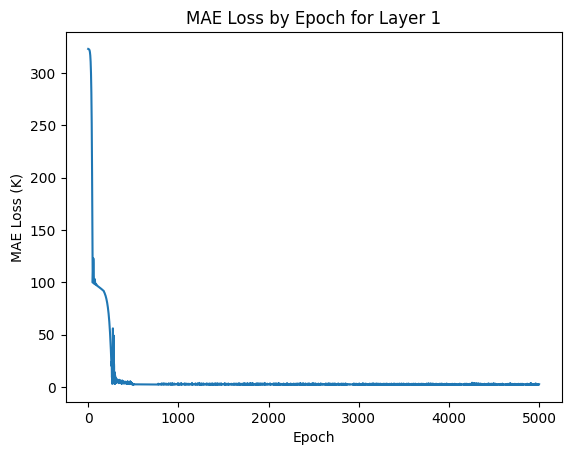

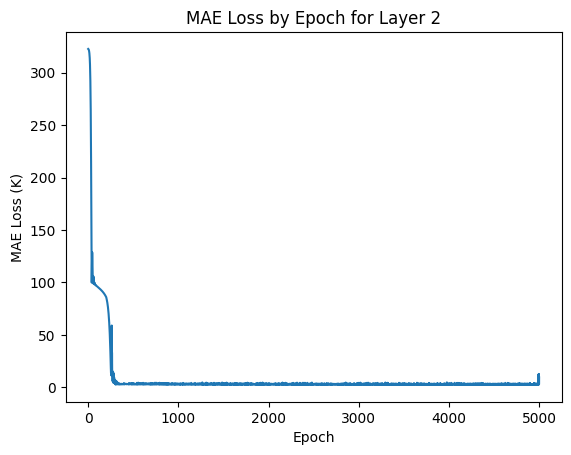

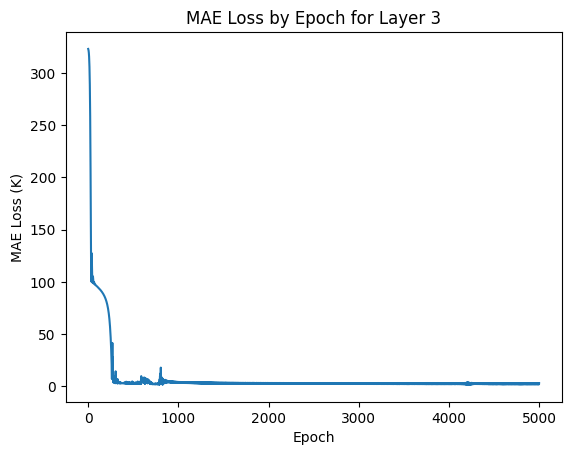

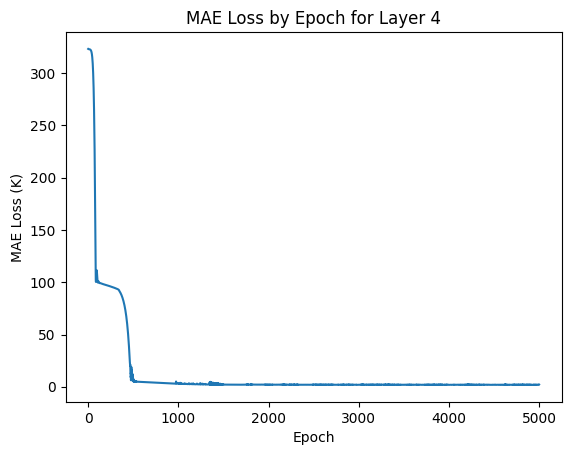

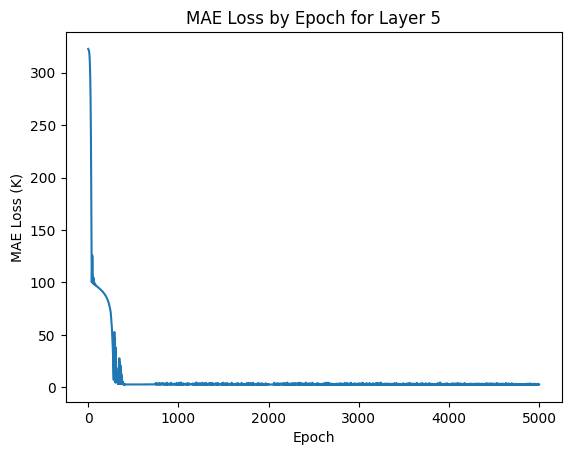

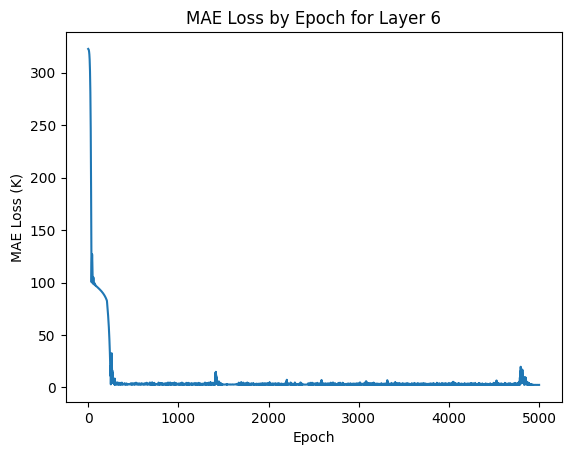

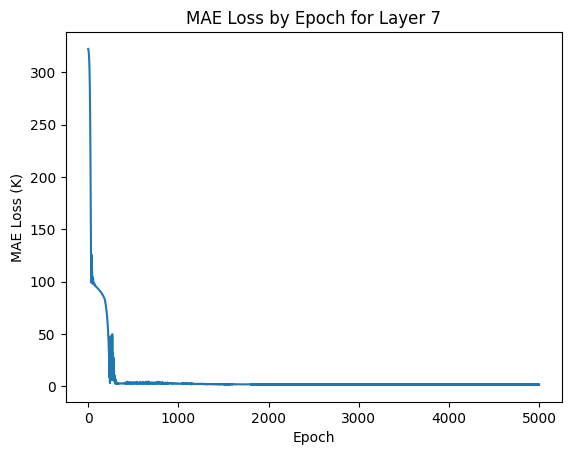

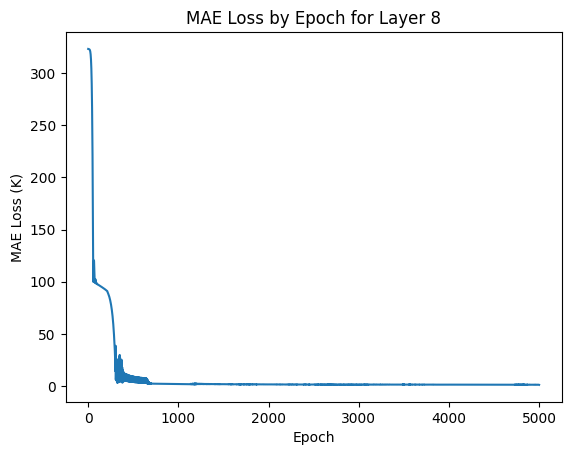

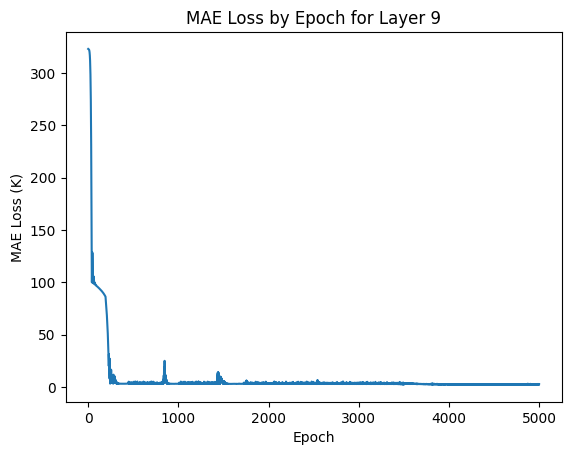

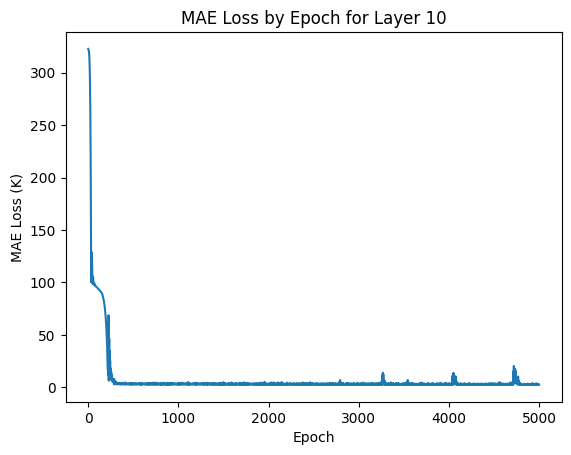

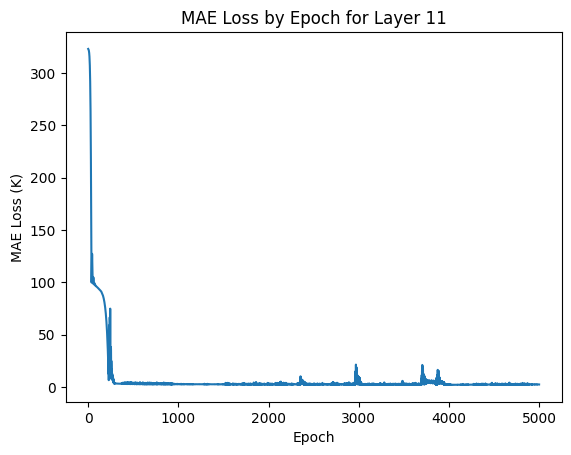

In [143]:
for layer in layers:
    plt.plot(layer['train losses'])

    plt.title(f"MAE Loss by Epoch for {layer['col'].capitalize()}")
    plt.xlabel("Epoch")
    plt.ylabel("MAE Loss (K)")

    plt.show()

In [144]:
test_losses = []
for layer in layers:
    input = layer['X_test']
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(input)
        loss = criterion(pred, target)
        test_losses.append(loss.item())

    y_test[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

layer 1 loss: 3.0536997318267822
layer 2 loss: 4.1145124435424805
layer 3 loss: 2.557804584503174
layer 4 loss: 2.2557363510131836
layer 5 loss: 2.7121877670288086
layer 6 loss: 2.497666358947754
layer 7 loss: 1.4548319578170776
layer 8 loss: 1.1488789319992065
layer 9 loss: 2.3682291507720947
layer 10 loss: 2.5287322998046875
layer 11 loss: 2.319530487060547


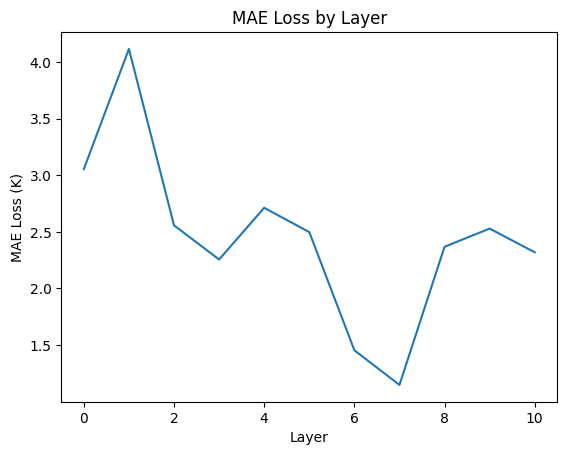

In [145]:
plt.plot(test_losses)

plt.title("MAE Loss by Layer")
plt.xlabel("Layer")
plt.ylabel("MAE Loss (K)")

plt.show()

In [146]:
def plot_comparison(pred, actual):
    plt.title("Temperature Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("Temperature")
    plt.plot(pred, 'r+', label='predicted')
    plt.plot(actual, 'g', label='actual')
    plt.show()

In [147]:
actual_df = y_test.iloc[:, :11]
pred_df = y_test.iloc[:, 11:]
pred_df.columns = actual_df.columns

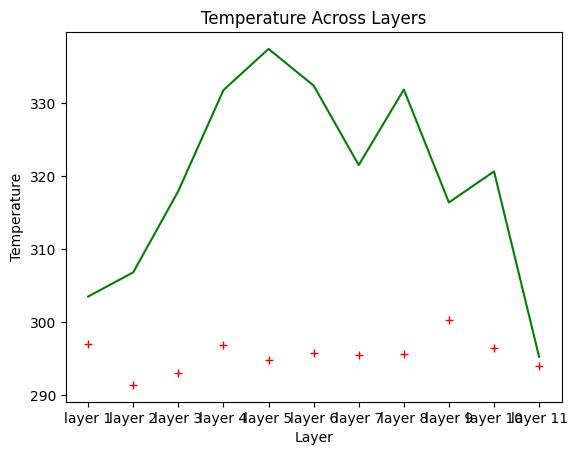

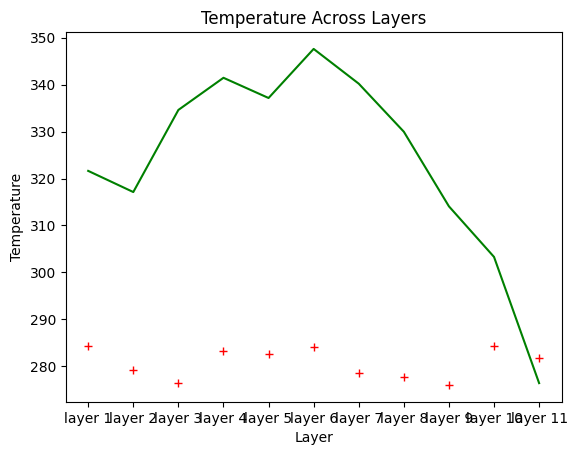

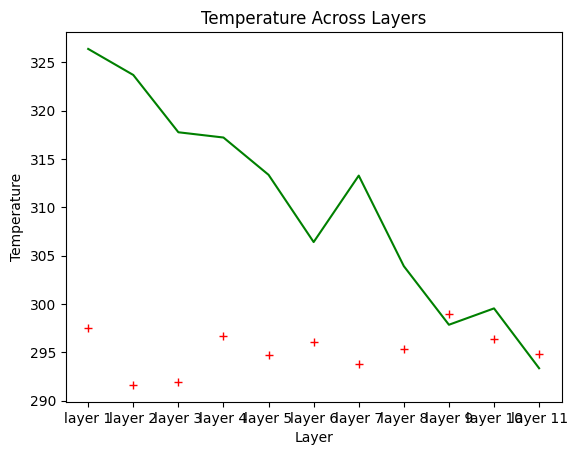

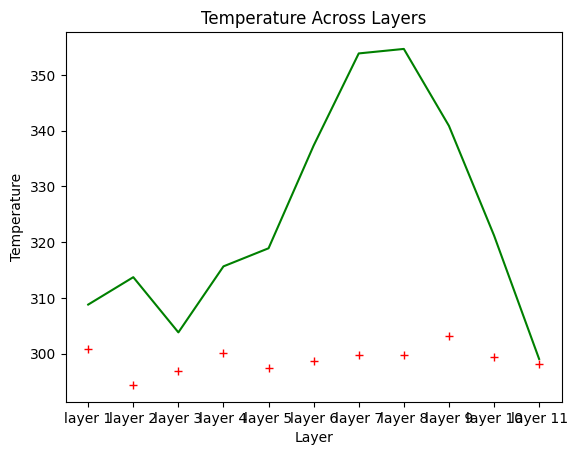

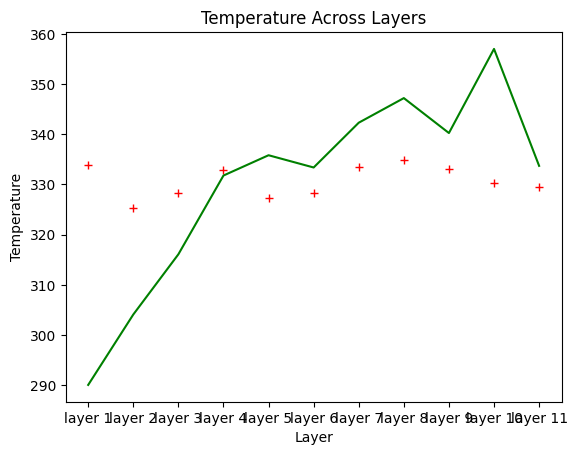

In [148]:


for i in range(0, len(y_test), int(len(y_test)/5)):
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual)